In [2]:
%cd /Users/helloworld/Home/Desktop/amugeona/LNS_floating/

/Users/helloworld/Home/Desktop/amugeona/LNS_floating


# Fluid surface dynamics

Based on: "Non-wetting impact of a sphere onto a bath and its application to bouncing droplets" by Galeano-Rios, Milewski, and Vanden-Broeck (2017)

Included forces:
- Gravity effects (Froude number)
- Surface tension (Weber number)
- Viscous dissipation (Reynolds number)

Notations:
- η: surface elevation
- ϕ: velocity potential
- w³: vertical vortical component


Key equations (2.15) from the paper:
- (2.15a): Laplace equation for velocity potential  
  
  $\Delta \phi = 0$

- (2.15b): vortical component evolution  
  
  $w_t^i = \frac{1}{Re} \Delta w^i$

- (2.15c): surface elevation evolution  
  
  $\eta_t = \phi_z + w^3$

- (2.15d): potential evolution at surface  
  
  $\phi_t = -\frac{1}{Fr} \eta + \frac{1}{We} \kappa[\eta] + \frac{2}{Re} \Delta_{H} \phi - p_s$

- (2.15e): vertical vortical component at surface  
  
  $w_t^3 = \frac{2}{Re} \Delta_H\left(\phi_z + w^3\right)$

- (2.17): $w^3 = \frac{2}{Re} \Delta_{H} \eta,\quad z = 0$
  

Boundary conditions (same as heat/Laplace solvers):
- Top ($z = D$): Surface with Dirichlet-like BC ($n$ determines location)
- Bottom ($z = 0$): Neumann BC ($\partial u/\partial z = 0$, elastic non-slip)
- Left & Right: Periodic BC





In [27]:
import numpy as np
from scipy.sparse import lil_matrix, eye
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.animation import FuncAnimation, PillowWriter
import math

In [28]:
import session_info
session_info.show()

#### Setting up constants

In [31]:
# physical params
L_in_cm = 50.0 # length in x-dir (cm)
D_in_cm = 5.0 # depth in z-dir (cm)
g_accel = 980.0 # gravitational acceleration (cm/s^2)
sigma = 74.9 # surface tension (dyne/cm)
rho = 1.0 # density (g/cm^3)
nu = 0.00894 # kinematic viscosity (cm^2/s)

# non-dimensionalization
Unit_length = 5.0
Unit_time = 0.1 # adjust....
Unit_velocity = Unit_length / Unit_time

# Numerical parameters
nx = 200 # n grid points in x-dir
nz = 40 # n grid points in z-dir
nt = 1000 # n time steps
total_time = 5.0 # seconds

# dimensionless params
L = L_in_cm / Unit_length
D = D_in_cm / Unit_length
T_total = total_time / Unit_time

# dimensionless numbers (eqn 2.14 in Galeano-Rios et al. 2017)
# Fr = V^2/(gL), We = ρV^2L/σ, Re = LV/ν
Fr = (Unit_velocity**2) / (g_accel * Unit_length_in_cm)
We = (rho * (Unit_velocity**2) * Unit_length_in_cm) / sigma
Re = (Unit_velocity * Unit_length_in_cm) / nu

print(f"Dimless params: Froude number, Weber number, Reynolds number")
print(f"Fr: {Fr:.4f}, We: {We:.4f}, Re: {Re:.4f}")

# derived numerical constants
dx = L / nx
dz = D / nz
dt = T_total / nt

print(f"  Froude number Fr = V²/(gL) = {Fr:.4f}")
print(f"  Weber number  We = ρV²L/σ  = {We:.4f}")
print(f"  Reynolds number Re = VL/ν  = {Re:.2f}")
print(f"\nGrid: {nx} x {nz} points, dt = {dt:.6f}")
print(f"CFL-like: γ_x = {dt/dx**2:.2f}, γ_z = {dt/dz**2:.2f}")


Dimless params: Froude number, Weber number, Reynolds number
Fr: 0.5102, We: 166.8892, Re: 27964.2058
  Froude number Fr = V²/(gL) = 0.5102
  Weber number  We = ρV²L/σ  = 166.8892
  Reynolds number Re = VL/ν  = 27964.21

Grid: 200 x 40 points, dt = 0.050000
CFL-like: γ_x = 20.00, γ_z = 80.00


#### Initial and boundary settings

In [32]:
# def surface_forcing(x, t):
#     """
#     Top boundary forcing func
#     """
#     return 50.0 + 50.0 * np.sin(2*math.pi*5*x/L) 

# def initial_potential(x, z):
#     """
#     Initial potential ϕ(x, z, t=0); start with zero potential
#     """
#     return 0.0

# def initial_w3(x):
#     """
#     Initial vertical vortical component w3(x, t=0)
#     From eqn (2.17) in Galeano-Rios et al. 2017: w^3 = 2/Re Δ_H η
#     """
#     return 0.0
    
def initial_eta(x):
    """
    Initial surface elevation, just changed to sin/cos to gaussian bump
    """
    x0 = L/2 # center of the domain
    sigma_x = L/10 # width
    amplitude = 0.05 # small but visible
    return amplitude * np.exp(-(x-x0)**2 / (2*sigma_x**2))


In [9]:
# Index conversion func

def to_1d_index(i, j):
    """
    Convert 2D grid indices to 1D array index
    """
    return i * nx + j

def to_2d_index(idx):
    """
    Convert 1D array index to 2D grid indices (i, j)
    """
    i = idx // nx
    j = idx % nx
    return i, j
    

#### Arry initialization

In [33]:
# main things
eta = np.zeros(nx) # surf elevation η(x, t)
phi = np.zeros((nz, nx)) # velocity potential ϕ(x, z, t)
w3 = np.zeros(nx) # vertical vortical component w^3(x, t) at surface

x_vec = np.linspace(0, L, nx)
z_vec = np.linspace(0, D, nz)

for j in range(nx):
    eta[j] = initial_eta(x_vec[j])

# # init cond
# for j in range(nx):
#     x_pos = j*delta_x
#     eta[j] = initial_surface_elevation(x_pos)
#     w3[j] = initial_w3(x_pos)
#     for i in range(nz):
#         z_pos = i*delta_z
#         phi[i, j] = initial_potential(x_pos, z_pos)


#### Operators

In [34]:
def build_Delta_H(n, dx):
    """Horizontal Laplacian for periodic BC"""
    D = lil_matrix((n, n))
    for j in range(n):
        D[j, j] = -2.0 / dx**2
        D[j, (j+1) % n] = 1.0 / dx**2
        D[j, (j-1) % n] = 1.0 / dx**2
    return D.tocsr()

def build_Laplace_matrix(nx, nz, dx, dz):
    """Build matrix for Δϕ = 0 with BCs"""
    N = nx * nz
    A = lil_matrix((N, N))
    alpha = (dz / dx)**2
    
    for i in range(nz):
        for j in range(nx):
            idx = i * nx + j
            
            # Laplacian coefficients
            A[idx, idx] = -2*alpha - 2
            
            # x-neighbors (periodic)
            A[idx, i*nx + (j+1)%nx] = alpha
            A[idx, i*nx + (j-1)%nx] = alpha
            
            # z-neighbors
            if i > 0:
                A[idx, (i-1)*nx + j] = 1
            else:  # Bottom: Neumann BC ∂ϕ/∂z = 0
                A[idx, (i+1)*nx + j] = 2
            
            if i < nz - 1:
                A[idx, (i+1)*nx + j] = 1
            # Top: Dirichlet BC handled in RHS
    
    return A.tocsr()

def curvature(eta, dx):
    """Compute κ[η] = ∂²η/∂x² (linearized)"""
    kappa = np.zeros_like(eta)
    n = len(eta)
    for j in range(n):
        kappa[j] = (eta[(j+1)%n] - 2*eta[j] + eta[(j-1)%n]) / dx**2
    return kappa

# Build matrices
Delta_H = build_Delta_H(nx, dx)
A_laplace = build_Laplace_matrix(nx, nz, dx, dz)
I = eye(nx, format='csr')

#### Laplace eqn solver for ϕ: eqn (2.15a)

In [ ]:
# def build_laplace_system():
#     """
#     Build system mat for Laplace eqn Δϕ = 0 with BCs:
#     - Bottom (i=0): Neumann BC ∂ϕ/∂z = 0
#     - Top (i=nz-1): Dirichlet BC: from surface elevation
#     - Left & Right: Periodic BC

#     Similar to Mara's code
#     """
#     num_unknowns = nx * nz
#     A = lil_matrix((num_unknowns, num_unknowns))

#     alpha = (delta_z / delta_t) ** 2
#     coeff_center = -2.0 * alpha - 2.0

#     for i in range(nz):
#         for j in range(nx):
#             eq_idx = to_1d_index(i, j)  

#             # center
#             A[eq_idx, eq_idx] = coeff_center

#             # right neigh (periodic in x)
#             if j<nx-1:
#                 neighbor_idx = to_1d_index(i, j+1)
#             else:
#                 neighbor_idx = to_1d_index(i, 0)
#             A[eq_idx, neighbor_idx] = alpha

#             # left neigh (periodic in x)
#             if j>0:
#                 neighbor_idx = to_1d_index(i, j-1)
#             else:
#                 neighbor_idx = to_1d_index(i, nx-1)
#             A[eq_idx, neighbor_idx] = alpha
            
#             # top neigh
#             if i<nz-1:
#                 neighbor_idx = to_1d_index(i+1, j)
#                 A[eq_idx, neighbor_idx] = 1.0
#             # If i == nz-1 (top), Dirichlet BC handled in RHS
            
#             #bottom neigh (Neumann BC at i=0)
#             if i>0: 
#                 neighbor_idx = to_1d_index(i-1, j)
#                 A[eq_idx, neighbor_idx] = 1.0
#             else:
#                 # Neumann BC: mirror cond
#                 neighbor_idx = to_1d_index(i+1, j)
#                 A[eq_idx, neighbor_idx] = 2.0
            
#     return A.tocsr()
    

In [ ]:
# def solve_laplace_for_phi(A_laplace, phi_top):
#     """
#     Solve Laplace eqn Δϕ = 0 with top BC
#     phi_top: values of ϕ at the top surface (length nx)
#     """
#     num_unknowns = nz * nx
#     b = np.zeros(num_unknowns)

#     # Dirichlet BC at top
#     for j in range(nx):
#         eq_idx = to_1d_index(nz-1, j)
#         b[eq_idx] = -phi_top[j]

#     # solve
#     vec = spsolve(A_laplace, b)

#     # reshape to 2D
#     phi_new = np.zeros((nz, nx))
#     for idx in range(num_unknowns):
#         i, j = to_2d_index(idx)
#         phi_new[i, j] = vec[idx]

#     return phi_new

#### system matrices

In [ ]:
# %%time
# A_laplace = build_laplace_system()
# Delta_H = build_laplacian_horizontal(nx, delta_x, periodic=True)

CPU times: user 38 ms, sys: 6.83 ms, total: 44.8 ms
Wall time: 72 ms


In [ ]:
# # Idetity matrix for implicit time-stepping
# I_sparse = lil_matrix((nx, nx))

# for j in range(nx):
#     I_sparse[j, j] = 1.0
# I_sparse = I_sparse.tocsr()

#### Time

1. Step 1: Compute w^3 from η using equation (2.17)
   
   $w^3 = \frac{2}{Re} \Delta_H \eta$ 
   
   at $z = 0$

2. Step 2: Update ϕ at surface using (2.15d)
   
   $\phi_t = -\frac{1}{Fr} \eta + \frac{1}{We} \kappa[\eta] + \frac{2}{Re} \Delta_H \phi - p_s$

   $p_s = 0$ (no solid impact)

   Using implicit Euler:

   $ \left( I - \frac{2 \Delta t}{Re} \Delta_H \right) \varphi^{n+1} = \varphi^n - \frac{\Delta t}{Fr} \eta + \frac{\Delta t}{We} \kappa[\eta] $

3. Step 3: Solve Laplace eqn for ϕ in entire domain with new op boundary cond

4. Step 4: update surface elevation η using equation (2.15c)

   $\eta_t = \phi_z + w^3 \quad \text{at} \quad z = 0$

   Using (2.17): $w^3 = \frac{2}{Re} \Delta_H \eta$

   $\eta_t = \phi_z + \frac{2}{Re} \Delta_H \eta$

   Implicit euler:

   $(\eta^{k+1} - \eta^k)/\delta t = \phi_z^{k+1} + \frac{2}{Re} \Delta_H \eta^{k+1}$

   $\eta^{k+1} - \frac{2\delta t}{Re} \Delta_H \eta^{k+1} = \eta^k + \delta t\, \phi_z^{k+1}$

   $(I - \frac{2\delta t}{Re} \Delta_H) \eta^{k+1} = \eta^k + \delta t\, \phi_z^{k+1}$


In [35]:
%%time
print(f"Total steps: {nt}")

# backup for viz
eta_history = []
phi_history = []
w3_history = []
time_points = []
save_every = max(1, nt//100)

# time loop
for n in range(nt):
    # t_current = n*delta_t
    # t_next = (n+1)*delta_t

    #! Step 1 ===#
    w3 = (2.0 / Re) * Delta_H.dot(eta)

    #! Step 2 ===#

    # curvature
    kappa_eta = curvature(eta, delta_x)

    # current ϕ at top surface
    phi_surf = phi[-1, :]

    # LHS matrix for ϕ at surface: I - (2δt/Re) Δ_H
    A_phi = I - (2.0 * dt / Re) * Delta_H

    # build RHS
    b_phi = phi_surf - (dt / Fr) * eta + (dt / We) * kappa_eta

    # solve for ϕ^{k+1} at surface
    phi_surf_new = spsolve(A_phi, b_phi)

    #! Step 3 ===#

    b_laplace = np.zeros(nx * nz)
    for j in range(nx):
        b_laplace[(nz-1)*nx + j] = -phi_surf_new[j]
    
    phi_vec = spsolve(A_laplace, b_laplace)
    phi_new = phi_vec.reshape((nz, nx))

    #! Step 4 ===#

    phi_z = (phi_new[-1, :] - phi_new[-2, :]) / dz  # ∂ϕ/∂z at surface
    
    A_eta = I - (2*dt/Re) * Delta_H
    b_eta = eta + dt * phi_z
    eta_new = spsolve(A_eta, b_eta)
    
    #! var update for next iteration
    eta = eta_new
    phi = phi_new
    
    #! Save for viz
    if n % save_every == 0:
        eta_history.append(eta.copy())
        phi_history.append(phi.copy())
        time_points.append((n+1)*dt*Unit_time)
    
    #! progress bar
    if (n+1) % (nt//10) == 0:
        print(f"  {100*(n+1)/nt:3.0f}% complete | t = {(n+1)*dt*Unit_time:.3f}s | "
              f"max|η| = {np.max(np.abs(eta)):.6f}")



Total steps: 1000
   10% complete | t = 0.500s | max|η| = 0.006305
   20% complete | t = 1.000s | max|η| = 0.000895
   30% complete | t = 1.500s | max|η| = 0.000330
   40% complete | t = 2.000s | max|η| = 0.000111
   50% complete | t = 2.500s | max|η| = 0.000026
   60% complete | t = 3.000s | max|η| = 0.000011
   70% complete | t = 3.500s | max|η| = 0.000003
   80% complete | t = 4.000s | max|η| = 0.000000
   90% complete | t = 4.500s | max|η| = 0.000000
  100% complete | t = 5.000s | max|η| = 0.000000
CPU times: user 10.7 s, sys: 1.17 s, total: 11.9 s
Wall time: 12.3 s


#### Velocity field compute

- Velocity $u = \mathbf{u} = \nabla \phi + w$
- $u_x = \frac{\partial \phi}{\partial x} + w^1$
- $u_z = \frac{\partial \phi}{\partial z} + w^3$

In [19]:
u_x = np.zeros((nz, nx)) # horizontal velocity
u_z = np.zeros((nz, nx)) # vertical velocity

In [36]:
# compute ∂ϕ/∂x
for i in range(nz):
    for j in range(nx):
        # ∂ϕ/∂x (periodic)
        u_x[i, j] = (phi[i, (j+1)%nx] - phi[i, (j-1)%nx]) / (2*dx)
        
        # ∂ϕ/∂z
        if i == 0:
            u_z[i, j] = (phi[i+1, j] - phi[i, j]) / dz
        elif i == nz-1:
            u_z[i, j] = (phi[i, j] - phi[i-1, j]) / dz
        else:
            u_z[i, j] = (phi[i+1, j] - phi[i-1, j]) / (2*dz)

#     for j in range(nx-1):
#         if j==0: # left boundary periodic
#             u_x[i, j] = (phi[i, j+1] - phi[i, nx-1]) / (2* delta_x)
#         elif j==nx-1: # right boundary periodic
#             u_x[i, j] = (phi[i, 0] - phi[i, nx-2]) / (2* delta_x)
#         else: # interior
#             u_x[i, j] = (phi[i, j+1] - phi[i, j-1]) / (2* delta_x)

# # compute ∂ϕ/∂z
# for i in range(nz):
#     for j in range(nx):
#         if i == 0:  # Bottom boundary
#             u_z[i, j] = (phi[i + 1, j] - phi[i, j]) / delta_z
#         elif i == nz - 1:  # Top boundary
#             u_z[i, j] = (phi[i, j] - phi[i - 1, j]) / delta_z
#         else:  # Interior
#             u_z[i, j] = (phi[i + 1, j] - phi[i - 1, j]) / (2 * delta_z)

#### dataviz

In [37]:
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
rcParams['axes.grid'] = False  # Remove the gray grid
import seaborn as sns
sns.set_style("white")  # Use white style without grid

import os

/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_935/1257211965.py:104: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_935/1257211965.py:104: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_935/1257211965.py:105: UserWarning: Glyph 8711 (\N{NABLA}) missing from font(s) Arial.
  plt.savefig('01_Surface_Dynamics/Outputs/fluid_dynamics_improved.png', dpi=300, bbox_inches='tight')
/var/folders/vq/95vzgtgx27v4ns1zwzj6dzw00000gn/T/ipykernel_935/1257211965.py:105: UserWarning: Glyph 8733 (\N{PROPORTIONAL TO}) missing from font(s) Arial.
  plt.savefig('01_Surface_Dynamics/Outputs/fluid_dynamics_improved.png', dpi=300, bbox_inches='tight')
/Users/helloworld/miniconda3/envs/scanpy/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8711 (\N{NABLA}) missing fr

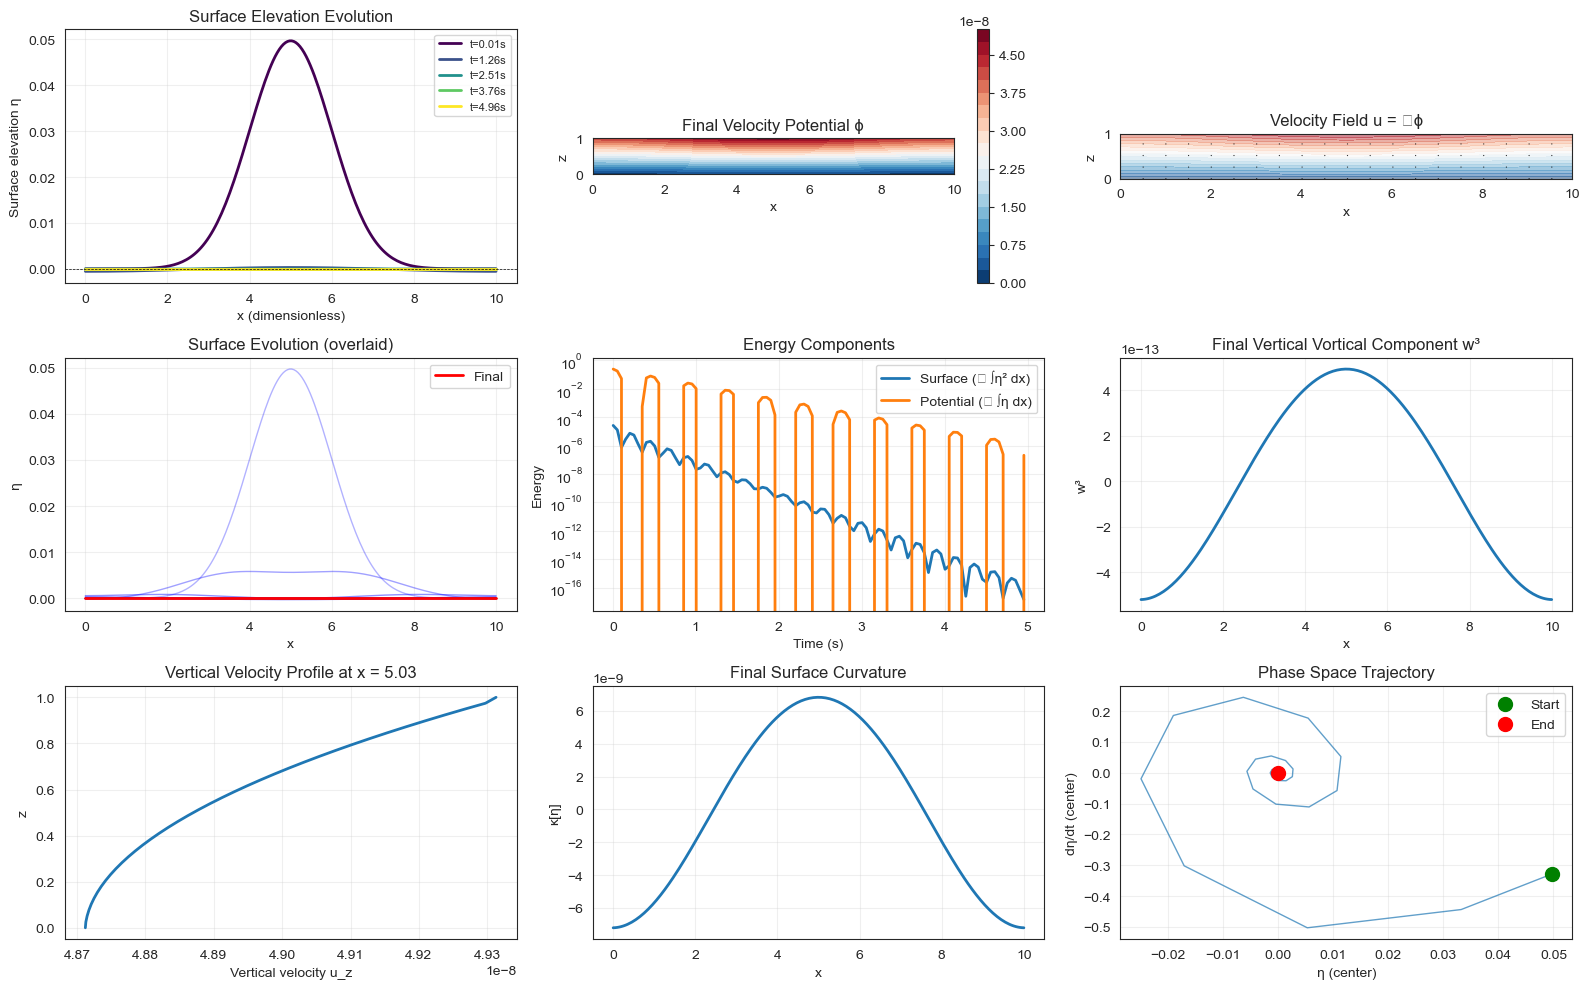

In [38]:
X, Z = np.meshgrid(x_vec, z_vec)

fig = plt.figure(figsize=(16, 10))

#! 1. Surface evolution
ax1 = fig.add_subplot(3, 3, 1)
times_to_plot = [0, len(eta_history)//4, len(eta_history)//2, 3*len(eta_history)//4, -1]
colors = plt.cm.viridis(np.linspace(0, 1, len(times_to_plot)))
for idx, color in zip(times_to_plot, colors):
    ax1.plot(x_vec, eta_history[idx], label=f't={time_points[idx]:.2f}s', 
             linewidth=2, color=color)
ax1.set_xlabel('x (dimensionless)')
ax1.set_ylabel('Surface elevation η')
ax1.set_title('Surface Elevation Evolution')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='k', linestyle='--', linewidth=0.5)

#! 2. Final velocity potential
ax2 = fig.add_subplot(3, 3, 2)
c2 = ax2.contourf(X, Z, phi, levels=20, cmap='RdBu_r')
ax2.set_xlabel('x')
ax2.set_ylabel('z')
ax2.set_title('Final Velocity Potential ϕ')
ax2.set_aspect('equal')
plt.colorbar(c2, ax=ax2)

#! 3. Velocity field
ax3 = fig.add_subplot(3, 3, 3)
skip = max(1, nx//20)
ax3.contourf(X, Z, phi, levels=15, cmap='RdBu_r', alpha=0.5)
Q = ax3.quiver(X[::skip, ::skip], Z[::skip, ::skip],
               u_x[::skip, ::skip], u_z[::skip, ::skip],
               scale=10, alpha=0.8, width=0.003)
ax3.set_xlabel('x')
ax3.set_ylabel('z')
ax3.set_title('Velocity Field u = ∇ϕ')
ax3.set_aspect('equal')

#! 4. Surface at different times
ax4 = fig.add_subplot(3, 3, 4)
for idx in range(0, len(eta_history), len(eta_history)//10):
    alpha = 0.3 + 0.7 * idx / len(eta_history)
    ax4.plot(x_vec, eta_history[idx], alpha=alpha, color='blue', linewidth=1)
ax4.plot(x_vec, eta_history[-1], color='red', linewidth=2, label='Final')
ax4.set_xlabel('x')
ax4.set_ylabel('η')
ax4.set_title('Surface Evolution (overlaid)')
ax4.legend()
ax4.grid(True, alpha=0.3)

#! 5. Energy
ax5 = fig.add_subplot(3, 3, 5)
surface_energy = [(1/We)*np.sum(e**2)*dx for e in eta_history]
potential_energy = [(1/Fr)*np.sum(e)*dx for e in eta_history]
ax5.plot(time_points, surface_energy, label='Surface (∝ ∫η² dx)', linewidth=2)
ax5.plot(time_points, potential_energy, label='Potential (∝ ∫η dx)', linewidth=2)
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Energy')
ax5.set_title('Energy Components')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

#! 6. w^3 evolution
ax6 = fig.add_subplot(3, 3, 6)
ax6.plot(x_vec, w3, linewidth=2)
ax6.set_xlabel('x')
ax6.set_ylabel('w³')
ax6.set_title('Final Vertical Vortical Component w³')
ax6.grid(True, alpha=0.3)

#! 7. Centerline velocity
ax7 = fig.add_subplot(3, 3, 7)
j_center = nx // 2
ax7.plot(u_z[:, j_center], z_vec, linewidth=2)
ax7.set_ylabel('z')
ax7.set_xlabel('Vertical velocity u_z')
ax7.set_title(f'Vertical Velocity Profile at x = {x_vec[j_center]:.2f}')
ax7.grid(True, alpha=0.3)

#! 8. Surface curvature
ax8 = fig.add_subplot(3, 3, 8)
kappa_final = curvature(eta, dx)
ax8.plot(x_vec, kappa_final, linewidth=2)
ax8.set_xlabel('x')
ax8.set_ylabel('κ[η]')
ax8.set_title('Final Surface Curvature')
ax8.grid(True, alpha=0.3)

#! 9. Phase space
ax9 = fig.add_subplot(3, 3, 9)
eta_center = [e[nx//2] for e in eta_history]
deta_center = np.gradient(eta_center, time_points[1] - time_points[0])
ax9.plot(eta_center, deta_center, linewidth=1, alpha=0.7)
ax9.scatter(eta_center[0], deta_center[0], c='green', s=100, label='Start', zorder=5)
ax9.scatter(eta_center[-1], deta_center[-1], c='red', s=100, label='End', zorder=5)
ax9.set_xlabel('η (center)')
ax9.set_ylabel('dη/dt (center)')
ax9.set_title('Phase Space Trajectory')
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('01_Surface_Dynamics/Outputs/fluid_dynamics_improved.png', dpi=300, bbox_inches='tight')
plt.show()


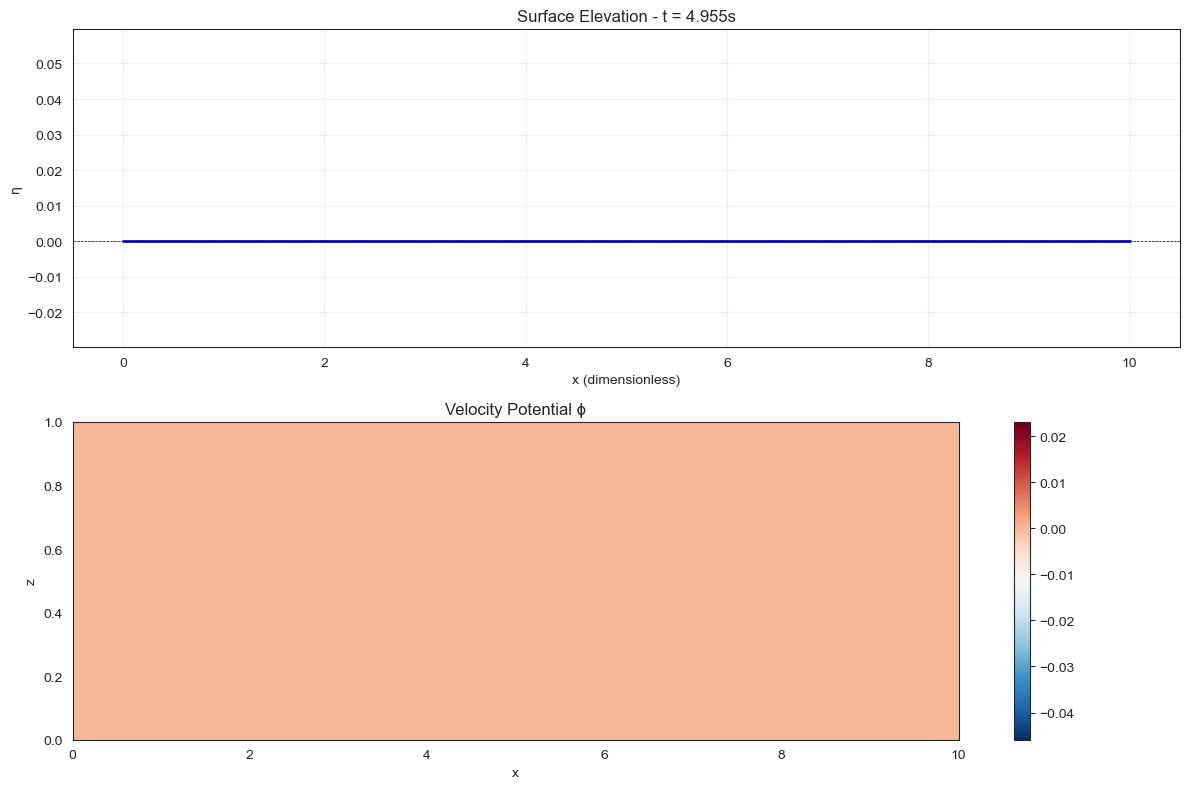

In [40]:
fig_anim, axes = plt.subplots(2, 1, figsize=(12, 8))

# Surface evolution
line_surf, = axes[0].plot(x_vec, eta_history[0], 'b-', linewidth=2)
axes[0].fill_between(x_vec, 0, eta_history[0], alpha=0.3)
axes[0].set_xlabel('x (dimensionless)')
axes[0].set_ylabel('η')
axes[0].set_ylim([min(np.min(e) for e in eta_history)*1.2,
                  max(np.max(e) for e in eta_history)*1.2])
axes[0].grid(True, alpha=0.3)
axes[0].axhline(0, color='k', linestyle='--', linewidth=0.5)
title_surf = axes[0].set_title(f'Surface Elevation - t = {time_points[0]:.3f}s')

# Potential field
vmin = min(np.min(p) for p in phi_history)
vmax = max(np.max(p) for p in phi_history)
im_phi = axes[1].imshow(phi_history[0], origin='lower', extent=[0, L, 0, D],
                        aspect='auto', cmap='RdBu_r', vmin=vmin, vmax=vmax)
axes[1].set_xlabel('x')
axes[1].set_ylabel('z')
axes[1].set_title('Velocity Potential ϕ')
plt.colorbar(im_phi, ax=axes[1])

def animate(frame):
    line_surf.set_ydata(eta_history[frame])
    
    for coll in axes[0].collections:
        coll.remove()
    axes[0].fill_between(x_vec, 0, eta_history[frame], alpha=0.3)
    
    im_phi.set_data(phi_history[frame])
    title_surf.set_text(f'Surface Elevation - t = {time_points[frame]:.3f}s')
    
    return line_surf, im_phi

anim = FuncAnimation(fig_anim, animate, frames=len(eta_history),
                    interval=50, blit=False, repeat=True)

writer = PillowWriter(fps=5)
anim.save('01_Surface_Dynamics/Outputs/fluid_dynamics_animation_improved_slower.gif', writer=writer, dpi=300)

plt.tight_layout()
plt.show()